In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [2]:
# Lets import the data for January
!wget https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-01.parquet -P ../data

--2022-05-22 11:27:02--  https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-01.parquet
Resolving nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)... 54.231.167.57
Connecting to nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)|54.231.167.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11886281 (11M) [binary/octet-stream]
Saving to: ‘../data/fhv_tripdata_2021-01.parquet.1’

fhv_tripdata_2021-0 100%[===================>]  11.33M  --.-KB/s    in 0.1s    

2022-05-22 11:27:03 (105 MB/s) - ‘../data/fhv_tripdata_2021-01.parquet.1’ saved [11886281/11886281]



In [3]:
# Lets import the data for February
!wget https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-02.parquet -P ../data

--2022-05-22 11:27:03--  https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-02.parquet
Resolving nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)... 52.217.160.153
Connecting to nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)|52.217.160.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10645466 (10M) [binary/octet-stream]
Saving to: ‘../data/fhv_tripdata_2021-02.parquet.1’

fhv_tripdata_2021-0 100%[===================>]  10.15M  --.-KB/s    in 0.1s    

2022-05-22 11:27:03 (102 MB/s) - ‘../data/fhv_tripdata_2021-02.parquet.1’ saved [10645466/10645466]



In [4]:
# Q1 Records for January
df = pd.read_parquet('../data/fhv_tripdata_2021-01.parquet')

# Total records
df.shape[0]

1154112

In [5]:
# Q2 Lets get duration
df['duration'] = df.dropOff_datetime - df.pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

# Average duration
df.duration.mean(), df.duration.median()

(19.1672240937939, 13.4)

In [6]:
# Q2.2 Lets get the distribution of the duration
print(round(df.duration.describe(),2))


print(round(df.duration.describe(percentiles=[0.9, 0.95,0.99])),2)

count    1154112.00
mean          19.17
std          398.69
min            0.02
25%            7.77
50%           13.40
75%           22.28
max       423371.05
Name: duration, dtype: float64
count    1154112.0
mean          19.0
std          399.0
min            0.0
50%           13.0
90%           36.0
95%           47.0
99%           90.0
max       423371.0
Name: duration, dtype: float64 2


/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

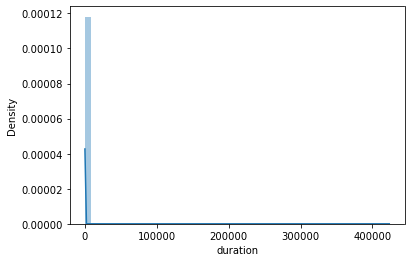

In [7]:
# Highly skewed distribution
sns.distplot(df.duration)

In [8]:
# Keeping rides between 1 and 60 minutes

df_filtered = df[(df.duration >= 1) & (df.duration <= 60)]

# Number of records dropped

print(df.shape[0] - df_filtered.shape[0])

44286


In [9]:
# Q3
print("Missing Values for each column \n\n", df_filtered.isnull().sum())

df_filtered[['PUlocationID', 'DOlocationID']] = df_filtered[['PUlocationID', 'DOlocationID']].fillna(-1)

print("Missing Values for each column after imputation \n\n", df_filtered.isnull().sum())

missing_perc = (df_filtered.PUlocationID == -1).astype(int).sum()/df_filtered.shape[0]

print(f"Missing percentage of Pu location {missing_perc:.0%}")


Missing Values for each column 

 dispatching_base_num            0
pickup_datetime                 0
dropOff_datetime                0
PUlocationID               927008
DOlocationID               147907
SR_Flag                   1109826
Affiliated_base_number        773
duration                        0
dtype: int64


/tmp/ipykernel_11663/2939371770.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[['PUlocationID', 'DOlocationID']] = df_filtered[['PUlocationID', 'DOlocationID']].fillna(-1)


Missing Values for each column after imputation 

 dispatching_base_num            0
pickup_datetime                 0
dropOff_datetime                0
PUlocationID                    0
DOlocationID                    0
SR_Flag                   1109826
Affiliated_base_number        773
duration                        0
dtype: int64
Missing percentage of Pu location 84%


In [10]:
# defining a function to quickly read and prepare data
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.pickup_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.dropOff_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    categorical = ['PUlocationID', 'DOlocationID']
    
    df[categorical] = df[categorical].fillna(-1)
    df[categorical] = df[categorical].astype(str)
    
    return df

In [11]:
# Reading and preparing the dataset
df_train = read_dataframe('../data/fhv_tripdata_2021-01.parquet')
df_val = read_dataframe('../data/fhv_tripdata_2021-02.parquet')

In [12]:
# Checking the size of datasets
len(df_train), len(df_val)

(1109826, 990113)

In [13]:
# defing feature types
categorical = ['PUlocationID', 'DOlocationID'] #'PULocationID', 'DOLocationID']

# applying one hot encoding
dv = DictVectorizer()

train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [14]:
#Q4 Get the number of columns
X_train.shape[1]

525

In [15]:
# defining the target
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
#Q5 training the regression model and getting RMSE on training data
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

print(mean_squared_error(y_train, y_pred, squared=False))

10.5285191072072


In [17]:
#Q6 Evaluating the model on validation set
y_pred = lr.predict(X_val)

print(mean_squared_error(y_val, y_pred, squared=False))

11.014283163400654
